# Determining the Tradeoff

### Loading the data

Let's continue with our customer churn dataset.  We can begin by loading our data and training a machine learning model.

In [2]:
import pandas as pd
url = "https://raw.githubusercontent.com/jigsawlabs-student/logistic-regression/master/0-classification-fundamentals/3-metrics-for-classification/coerced_customer_churn.csv"
df = pd.read_csv(url, index_col = 0)

X = df.drop('Churn', axis = 1)
y = df['Churn']

In [5]:
# X[:2]

In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [9]:
# X_scaled[:2]

In [11]:
X_df = pd.DataFrame(data = X_scaled, columns = X.columns)
# X_df[:2]

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_df, y,
                                                    test_size = .4,
                                                    random_state = 1, stratify = y)
X_validate, X_test, y_validate, y_test = train_test_split(X_test, y_test, 
                                                          test_size = .5,
                                                          random_state = 1, stratify = y_test)

In [13]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver = "lbfgs",
                           max_iter = 5000, class_weight = 'balanced',
                           random_state = 1).fit(X_train, y_train)

In [14]:
# y.mean()

# sum 3*p^y + (1 - p)^(1 - y)

0.2653698707936959

In [16]:
model.score(X_validate, y_validate)

0.7260468417317246

### Modifying the Threshold

In [17]:
from sklearn.metrics import precision_score, recall_score

In [18]:
recall_score(y_validate, model.predict(X_validate)), precision_score(y_validate, model.predict(X_validate))

(0.7754010695187166, 0.48986486486486486)

In [43]:
proba_preds = model.predict_proba(X_validate)[:, 1]

proba_preds[:2]

array([0.84492016, 0.0071531 ])

In [37]:
threshold = .3
predictions_2 = (model.predict_proba(X_validate)[:, 1] > threshold).astype('int') 

In [38]:
recall_score(y_validate, predictions_2), precision_score(y_validate, predictions_2)

(0.9144385026737968, 0.4170731707317073)

Now, let's try to improve our recall score, and thus detect more customers who will churn, by lowering our threshold for making a positive prediction.  We can do so, predicting those with a `prob_a` score of only .40 to be positive.  This will have our model cast a wider net, by including observations that previously did not meet the threshold to be declared positive.

In [74]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_validate, model.predict_proba(X_validate)[:, 1])

In [48]:
precision.shape, recall.shape, thresholds.shape

((1343,), (1343,), (1342,))

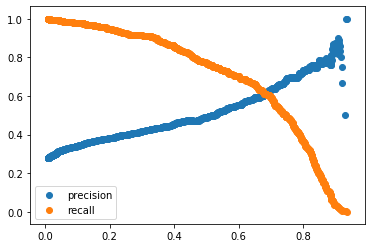

In [54]:
import matplotlib.pyplot as plt

plt.scatter(x = thresholds, y = precision[1:], label = 'precision')

plt.scatter(x = thresholds, y = recall[1:], label = 'recall')
plt.legend()

In [56]:
prec_rec_df = pd.DataFrame({'threshold': threshold, 'precision': precision[1:], 'recall': recall[1:]})

In [72]:
# prec_rec_df[(prec_rec_df['precision'] > .3) & (prec_rec_df['precision'] < .31 )]

array([ True,  True,  True])

In [67]:
threshold = .3
test_predictions = (model.predict_proba(X_test)[:, 1] > threshold).astype('int')
test_predictions[:3]

array([0, 1, 1])

In [69]:
from sklearn.metrics import precision_score, recall_score
recall_score(y_test, test_predictions), precision_score(y_test, test_predictions)

(0.93048128342246, 0.42962962962962964)

So above we simply check if the score is above our threshold of `.4`.  Those. that are above .4 are now declared positive.  Doing so should now increase our recall score, and decrease our precision score.  Let's see it.

In [71]:
recall_score(y_validate, threshold_preds), precision_score(y_validate, threshold_preds)

(0.9168975069252078, 0.47763347763347763)

### Plotting Precision and Recall Scores

In [72]:
from sklearn.metrics import precision_recall_curve
y_val_preds = model.predict_proba(X_validate)
precision, recall, thresholds = precision_recall_curve(y_validate,
                                                       y_val_preds[:, 1])


> We are returned the scores for the precision, recall, and related thresholds.

In [73]:
thresholds[:3], recall[:3], precision[:3], 

(array([0.00926133, 0.00933168, 0.00937045]),
 array([1.        , 0.99722992, 0.99722992]),
 array([0.26388889, 0.2633504 , 0.26354319]))

### Solving with Code

Of course, to find the exact number we can loop through some different thresholds calculating the precision and accuracy for each one.

In [79]:
df = pd.DataFrame({'thresholds':thresholds, 'precision':precision[1:], 'recalls': recall[1:]})

In [80]:
df[:3]

,thresholds,precision,recalls
0,0.009261,0.263350,0.99723
1,0.009332,0.263543,0.99723
2,0.009370,0.263736,0.99723


> Check for a threshold where precision is .5.

We find where the precision is .5 (or thereabouts).

In [81]:
df[(df['precision'] < .5001) & (df['precision'] > .4999)]

,thresholds,precision,recalls
761,0.462763,0.5,0.836565


So we can see that we can have a recall score of .83 if we allow precision to drop to .5.  And we can do so with a threshold of .46.

In [85]:
threshold = .46

threshold_preds = (model.predict_proba(X_validate) > threshold)[:, 1]
threshold_preds[:3]

recall_score(y_validate, threshold_preds), precision_score(y_validate, threshold_preds)

(0.8365650969529086, 0.49834983498349833)

In [86]:
threshold_preds.astype('int')[:5]

array([1, 1, 1, 0, 0])

### Wrapping Up

Finally, because precision and recall occur in tradeoffs, data scientists often use an average of precision and recall to summarize how well a model is performing on both of these metrics.  Except, the kind of average they use is called a harmonic mean.  The harmonic mean of precision and recall is the following: 

$F_1 = \frac{p*r}{p + r}$

In [87]:
from sklearn.metrics import f1_score

f1_score(y_validate, threshold_preds)

0.6246122026887281

> To find exactly where the harmonic mean peaks, we can again loop through various thresholds.

In [89]:
from sklearn.metrics import f1_score

In [90]:
import numpy as np 
thresholds = np.linspace(.30, .70, 100)

In [91]:
thresholds_and_f1_scores = []
for threshold in thresholds:
    threshold_preds = (model.predict_proba(X_validate) > threshold)[:, 1]
    score = f1_score(y_validate, threshold_preds)
    thresholds_and_f1_scores.append((threshold, score))

In [92]:
df = pd.DataFrame(thresholds_and_f1_scores, columns = ['threshold', 'f1'])

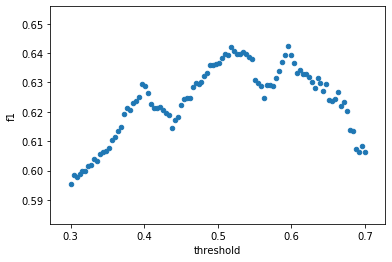

In [93]:
df.plot.scatter(x = 'threshold', y = 'f1')

So if our goal is to maximize the f1 score, we can see that this peaks right around .55.

### Summary

In this lesson, we saw how to balance precision and recall.  We saw that we can change the threshold from where we classify an observation as positive or negative with the following code:

```python
model.predict_proba(X_validate) > threshold
```

Then we saw how to plot the various tradeoffs with the precision_recall_curve.  The method takes in the true labels and the models predictions, and returns the precision and recall scores at various thresholds.

```python
y_val_preds = model.predict_proba(X_validate)
precision, recall, thresholds = precision_recall_curve(y_validate, y_val_preds[:, 1])
```

We then plot the threshold against the precision score, and the threshold against the recall score to better see the tradeoffs for our model.  

In [76]:
import kaggle